In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Transformation Et Manipulation Des Données<br>
    </h1>
    MovieLens - Préparation des données pour système de recommendations de films.<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle de La Sablonnière</b><br>
    <br>
    420-A56<br>
    <br>
</center>

# Introduction
    
Nous avons choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle décrit les notations des utilisateurs de MovieLens; un service de recommendation de films. Elle contient plus de 100K notations représentant plus de 9700 films. Ces notations ont été établit par plus de 600 utilisateurs entre mars 1996 et septembre 2018. Elle contient également les métadonnées sur 19 genres. Les données sont structurées dans 4 fichiers distincts.

<br>**tags.csv**

Fichier contenant les tags (quelques mots générés par les utilisateurs) de chaque film. Ces données ne sont pas utilisées dans ce projet dans un but de réduire la portée.

<br>**links.csv**

Fichier contenant les metadonnées permettant de lier un film à d'autres source de données. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock">movieId, imdbId, tmdbId</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|imdbId| Identifiant du film dans [Internet Movie Database](http://www.imdb.com).|
|tmdbId| Identifiant du film dans [The Movie DB](https://www.themoviedb.org).|    
</div>

<br>**ratings.csv**

Ce fichier contient les notations. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock">userId, movieId, rating, timestamp</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur dans cette base de données.|
|movieId| Identifiant du film dans cette base de données.|
|rating| Nombre d'étoiles attribuées avec une granularité de $\frac{1}{2}$. |
|timestamp| Date à laquelle la note a été entré. Encodée dans le format [UTC](https://tinyurl.com/32e6a5pc).|
</div>

<br>**movies.csv**

Ce fichier contient les métadonnées de chaque film. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock">movieId, title, genres</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur dans cette base de données.|
|title| Titre du film. Peut contenur l'année de parution.|
|genres| Genres. Liste de mots séparés par un 'pipe' (\|). |
</div>

<br>

L'objectif de ce projet est de préparer les données pour un éventuel système de recommentation de films. Nous allons examiner chaque fichier indépendamment et utiliser le web scraping afin de corriger, dans la mesure du possible, les informations manquantes. Finalement, nous allons produire 2 nouvelles base de données qui permettons l'implémentation d'un éventuel système de suggestions.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import time

from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfTransformer

from tqdm.notebook import tqdm

#
# imports faisant partie de nos propres modules
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.dataset.MovieLens as mvl
import helpers.WebScraping as scrap
import helpers.jupyter as jup

# Lecture de la base de données

Notre approche se veut la plus automatisée possible. Nous avons donc construit plusieurs modules python permettant de configurer et de rendre transparent nos processus. [config_overrides.json](./config_overrides.json) et [helpers](./helpers) donneront plus de détails.

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset
#
mvl_dataset = mvl.load(configs.dataset)

  0%|          | 0/978202 [00:00<?, ?it/s]

Unziping dataset/ml-latest-small.zip


# links.csv
    
Les informations contenues dans ce fichier serviront pour le web scraping. Il donc imporant d'en faire un survol rapide.

In [4]:
print("Links:", mvl_dataset.links.shape)
print("Head")
display(mvl_dataset.links.head())
clstr.show_types(mvl_dataset.links)
clstr.show_na(mvl_dataset.links);

Links: (9742, 3)
Head


,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


Types


,movieId,imdbId,tmdbId
Type,int64,object,object


Valeur manquante 8 (0.1%)


,movieId,imdbId,tmdbId
624,791,0113610,NaN
843,1107,0102336,NaN
2141,2851,0081454,NaN
3027,4051,0056600,NaN
5532,26587,0092337,NaN
5854,32600,0377059,NaN
6059,40697,0105946,NaN
7382,79299,0874957,NaN


* 9742 individus
* 3 variables (elles correspondent bien à la description)
* Les types sont **objet** pour imdbId et tmdbId à cause de leur nature. Noter les double zéro (00) dans imdbId. Cette transformation est faite par les modules python et non montrée dans ce notebook. movieId est numérique mais sert tout de même d'identifiant.
* Il manque quelques liens sur TMDB](https://www.themoviedb.org/). Les liens [IMDB](https://www.imdb.com/) seront par conséquent utilisés.

# movies.csv

In [5]:
print("Movies:", mvl_dataset.movies.shape)
print("Head")
display(mvl_dataset.movies.head())
clstr.show_types(mvl_dataset.movies)
clstr.show_na(mvl_dataset.movies);

Movies: (9742, 3)
Head


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Types


,movieId,title,genres
Type,int64,object,object


Valeur manquante 0 (0.0%)


* 9742 individus
* 3 variables (elles correspondent bien à la description)
* **title** et **genres** sont qualitatifs, movieId est numérique.
* noter que **genres** et "multimodal"; il peut prendre simultanément N modalités

Tel que décris plus haut, **title** contient l'année de parution. Nous allons l'extraire afin d'obtenir une nouvelle variable. Nous allons aussi tenter de l'enlever du titre.

In [6]:
def split_title_year(title, regex):
    x = regex.search(title)
    if x:
        title = x.group(1)
        year = x.group(2)
        year = int(year) if year else pd.NA
    else:
        year = pd.NA
    
    return pd.Series({"title": title, "year": year})

title_year_re = re.compile(configs.dataset.title_regex, flags=0)        
title_year = mvl_dataset.movies.title.apply(split_title_year, args=(title_year_re,))

#
# validation de l'extraction
#
print("Informations extraites:", title_year.shape)
print("Head")
display(title_year.head())
clstr.show_na(title_year);

Informations extraites: (9742, 2)
Head


,title,year
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995
3,Waiting to Exhale,1995
4,Father of the Bride Part II,1995


Valeur manquante 12 (0.1%)


,title,year
6059,Babylon 5,<NA>
9031,Ready Player One,<NA>
9091,Hyena Road,<NA>
9138,The Adventures of Sherlock Holmes and Doctor W...,<NA>
9179,Nocturnal Animals,<NA>
9259,Paterson,<NA>
9367,Moonlight,<NA>
9448,The OA,<NA>
9514,Cosmos,<NA>
9515,Maria Bamford: Old Baby,<NA>


Il manque quelques années de parution. Il est probablement possible de les fixer en utilisant **links.imdbId** avec le web scrapping.

In [7]:
def imdb_scap_year(response, index, imdbId):
    success = False
    if response.ok:
        bs = BeautifulSoup(response.text, "html.parser")

        imdb_info = bs.find("script", attrs={"type": "application/ld+json"})
        imdb_json = json.loads(imdb_info.text)
        date_published = scrap.get_nested_property(imdb_json, ["datePublished"])
        if not success and date_published:
            date_published = pd.to_datetime(date_published)
            year = date_published.year
            success = True

        imdb_info = bs.find("script", attrs={"type": "application/json"})
        imdb_json = json.loads(imdb_info.text)
        releaseYear = scrap.get_nested_property(imdb_json, 
                                                ["props", 
                                                 "pageProps", 
                                                 "mainColumnData", 
                                                 "releaseYear",
                                                 "year"])
        if not success and releaseYear:
            year = releaseYear
            success = True

    if success:
        return (index, year, response.url)
    else:
        return (index, None, response.url)

def imdb_scap_year_apply_results(final_results):
    for index, year, url in final_results:
        if year is None:
            print(url, title_year.title[index], "Failed")
        else:
            title_year.year[index] = year

#    
# corriger year via web scrapping avec imdb
#
year_na = title_year.year.isna()
year_link = mvl_dataset.links.imdbId[ year_na ]

if year_link.shape[0] > 0:
    with hlp.Profile() as year_profile:
        # par souci de temps d'iteration, nous avons parallelise les requetes
        results = scrap.imdb_requests_parallel(year_link,
                                               configs.web_scraping,
                                               imdb_scap_year,
                                               executor=configs.executor)
        imdb_scap_year_apply_results(results)
    print(f"Web scraping year: {year_profile.round_duration(2)}s")

# validation du scapping
clstr.show_na(title_year);

  0%|          | 0/12 [00:00<?, ?it/s]

Web scraping year: 2.14s
Valeur manquante 0 (0.0%)


In [8]:
#
# mettre a jour movies
#
mvl_dataset.movies["year"] = title_year.year.astype(np.int64)

Nous avons réussi à obtenir toutes les années. Nous devons inspecter sont effet de son retrait de **title**.

In [9]:
#
# validation effet extraction de l'annee de title
#
imdb_ids = mvl_dataset.links.imdbId[mvl_dataset.links.movieId == mvl_dataset.movies.movieId]

title = mvl_dataset.movies[["movieId", "year"]].copy()
title["title"] = title_year.title.copy()
title["imdbId"] = imdb_ids.copy()

def title_agregate(dataframe):
    return pd.Series({"imdbIds": dataframe.imdbId.unique(),
                      "years": dataframe.year.unique(),
                      "counts": dataframe.movieId.nunique()})

groups = title.groupby("title").apply(title_agregate)
groups.sort_values(by="counts", ascending=False, inplace=True)

print("Titre sans l'année et le nombre de films qui lui correspond")
display(groups.head())

Titre sans l'année et le nombre de films qui lui correspond


,imdbIds,years,counts
title,,,
Hamlet,"[0116477, 0040416, 0058175, 0171359, 0099726]","[1996, 1948, 1964, 2000, 1990]",5
"Christmas Carol, A","[0029992, 1067106, 0216621, 0188504]","[1938, 2009, 1999, 1977]",4
"Misérables, Les","[0113828, 0119683, 1707386, 0230534]","[1995, 1998, 2012, 2000]",4
Jane Eyre,"[0116684, 0036969, 0065911, 1229822]","[1996, 1944, 1970, 2011]",4
"Three Musketeers, The","[0108333, 0040876, 0072281, 1509767]","[1993, 1948, 1973, 2011]",4


Une inspection manuelle de [Hamlet 1996](http://www.imdb.com/title/tt0116477) et [Hamlet 1948](http://www.imdb.com/title/tt0040416) via IMDB permet de voir que l'année juxtaposée au titre est un identifiant unique. Nous devons donc garder **title** tel quel. La prochaine étape est d'enlever les éventuels doublons.

In [10]:
#
# validation doublons
#
print("Vérifier doublons")
print("Avant:", mvl_dataset.movies.shape)
mvl_dataset.movies.drop_duplicates(inplace=True)
print("Après:", mvl_dataset.movies.shape)

Vérifier doublons
Avant: (9742, 4)
Après: (9742, 4)


Aucun doublon trouvé. Nous allons analyser **genres**.

In [11]:
#
# validation modalites genres
#
def show_unique_genres(sort_effectif=False):
    genres_count = {}

    def add(genre):
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1
    
    for genres_str in mvl_dataset.movies.genres:
        if genres_str is None:
            add(None)
        else:
            genre_array = genres_str.split(configs.dataset.genre_splitter)
            for genre in genre_array:
                add(genre)

    genres_df = pd.Series(data=genres_count.values(),
                          index=genres_count.keys(),
                          name="# films")

    if sort_effectif:
        #genres_df /= mvl_dataset.movies.shape[0] / 100
        genres_df.sort_values(ascending=False, inplace=True)
    else:
        genres_df.sort_index(inplace=True)

    print("Unique genres:", genres_df.shape[0])
    display(genres_df.to_frame())
    
    return genres_df

show_unique_genres();

Unique genres: 20


,# films
(no genres listed),34
Action,1828
Adventure,1263
Animation,611
Children,664
Comedy,3756
Crime,1199
Documentary,440
Drama,4361
Fantasy,779


(no genres listed) semble être en fait des valeurs manquantes. Regardons les autres films ayant cette modalité.

In [12]:
#
# examiner (no genres listed)
#    
def show_no_genres():
    no_genres_crit = mvl_dataset.movies.genres.str.contains("(no genres listed)", regex=False)
    no_genres = mvl_dataset.movies[no_genres_crit]
    print("HEAD (no genres listed)", no_genres.shape[0])
    if no_genres.shape[0] > 0:
        display(no_genres.head())
    return no_genres.index
    
no_genres_index = show_no_genres()

HEAD (no genres listed) 34


,movieId,title,genres,year
8517,114335,La cravate (1957),(no genres listed),1957
8684,122888,Ben-hur (2016),(no genres listed),2016
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017
8782,129250,Superfast! (2015),(no genres listed),2015
8836,132084,Let It Be Me (1995),(no genres listed),1995


On voit que (no genres listed) est toujours utilisé seul; il représente bien les valeurs manquantes. Nous allons utiliser le web scrapping pour le remplacer.

In [13]:
def imdb_scap_genres(response, index, imdbId):
    success = False
    if response.ok:
        bs = BeautifulSoup(response.text, "html.parser")

        imdb_info = bs.find("script", attrs={"type": "application/ld+json"})
        imdb_json = json.loads(imdb_info.text)
                
        genres = scrap.get_nested_property(imdb_json, ["genre"])
        if not success and genres:
            success = True
        else:
            error = json.dumps(imdb_json, indent=4)
    else:
        error = response.reason

    if success:
        return (index, genres, response.url, None)
    else:
        
        return (index, None, response.url, error)

def imdb_scap_genres_apply_results(final_results, genres_splitter):
    for index, genres, url, error in final_results:
        if genres is None:
            if False:
                print()
                print(error)
                print()

            print(url, mvl_dataset.movies.title[index], "Failed")
        else:
            mvl_dataset.movies.loc[index, "genres"] = genres_splitter.join(genres)


#
# corriger genres via web scrapping avec imdb
#
genres_imdbIds = mvl_dataset.links.imdbId[no_genres_index]

if genres_imdbIds.shape[0] > 0:
    with hlp.Profile() as genres_profile:
        if True:
            results = scrap.imdb_requests_parallel(genres_imdbIds, 
                                                   configs.web_scraping, 
                                                   imdb_scap_genres,
                                                   executor=configs.executor)
            imdb_scap_genres_apply_results(results, configs.dataset.genre_splitter)
        else:
            # les resultats ne sont pas appliques ici
            # ce code n'existe que pour mesurer le gain du multithreading
            scrap.imdb_requests(genres_imdbIds, 
                                configs.web_scraping, 
                                imdb_scap_genres)
    print(f"Web scraping genres: {genres_profile.round_duration(2)}s")
        
show_unique_genres(sort_effectif=True)
show_no_genres();

  0%|          | 0/34 [00:00<?, ?it/s]

Web scraping genres: 4.59s
Unique genres: 24


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


HEAD (no genres listed) 0


Nous avons réussi à enlever (no genres listed) mais nous avons introduit de nouvelles modalités. Nous allons tenter d'en diminuer le nombre afin de contrôler la dimentionalité de **genres**. Nous allons donc:

* les modalités avec un effectif de $\le 4$ seront enlevées
* Music et Musical sont synonyme, nous gardons Musical
* IMAX n'est pas un genre mais bien un format de diffusion.

In [14]:
def split_genres_str(genres_str, splitter):
    return genres_str.split(splitter)

def clean_genres(genres_str, splitter, to_remove):
    if genres_str is None or not isinstance(genres_str, str):
        return genres_str
    
    genres_list = split_genres_str(genres_str, splitter)
    genres_set = set(genres_list)
    genres_set -= to_remove
    
    # bien que non portable, par souci d'efficacite
    # handler Music et Musical ici
    if "Music" in genres_set:
        genres_set.remove("Music")
        genres_set.add("Musical")

    genres_str = splitter.join(genres_set)
    if len(genres_str) == 0:
        genres_str = None

    return genres_str

#
# nettoyer les modalites de genres
# Music et Musical sont aussi gere dans clean_genres
#
to_remove = ["IMAX", "Short", "Biography", "Family", "History"]
to_remove = set(to_remove)
cleaned_genres = mvl_dataset.movies.genres.apply(clean_genres, 
                                                 splitter=configs.dataset.genre_splitter,
                                                 to_remove=to_remove)

mvl_dataset.movies["genres"] = cleaned_genres

print("Genres nettoyés")
genres_na = clstr.show_na(mvl_dataset.movies)
show_unique_genres(sort_effectif=True)
print(mvl_dataset.movies.shape)

Genres nettoyés
Valeur manquante 1 (0.0%)


,movieId,title,genres,year
9611,176601,Black Mirror,None,2011


Unique genres: 19


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


(9742, 4)


Certains films n'avaient que 1 seul genre et le retrait précédant crée 1 valeur manquante. Nous supprimons cet individu.

In [15]:
mvl_dataset.movies.drop(index=genres_na, axis=0, inplace=True, errors="ignore")

# validation retrain NA de genres
show_unique_genres(sort_effectif=True)
clstr.show_na(mvl_dataset.movies);

Unique genres: 18


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


Valeur manquante 0 (0.0%)


Il reste au final 18 modalités. Nous ajoutons **imdbId** afin d'avoir l'information dans une seule base de données.

In [16]:
#
# ajout imdbId a movies
#
mvl_dataset.movies = pd.merge(mvl_dataset.movies, 
                              mvl_dataset.links[["movieId", "imdbId"]],
                              how="left", 
                              on="movieId")

# pour faciliter la visualization, mettre imdbId au tout debut
mvl_dataset.movies.insert(1, 'imdbId', mvl_dataset.movies.pop('imdbId'))

# validation
print("Validation ajout imdbId")
display(mvl_dataset.movies.head())

Validation ajout imdbId


,movieId,imdbId,title,genres,year
0,1,0114709,Toy Story (1995),Comedy|Fantasy|Animation|Adventure|Children,1995
1,2,0113497,Jumanji (1995),Children|Adventure|Fantasy,1995
2,3,0113228,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,0114885,Waiting to Exhale (1995),Comedy|Romance|Drama,1995
4,5,0113041,Father of the Bride Part II (1995),Comedy,1995


# ratings.csv

In [17]:
print("Ratings", mvl_dataset.ratings.shape)
print("Head")
display(mvl_dataset.ratings.head())
clstr.show_types(mvl_dataset.ratings)
clstr.show_na(mvl_dataset.ratings);

Ratings (100836, 4)
Head


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Types


,userId,movieId,rating,timestamp
Type,int64,int64,float64,int64


Valeur manquante 0 (0.0%)


* **rating**, bien que montré en nombre flottant, est en fait un système d'étoiles où la mesure de base est $\frac{1}{2}$. Nous gardons en quantitatif pour le moment car il semble avantageux pour faire un lien avec les données dans **movies.csv**. L'implémentation du sytème de suggestion pourra décider s'il est pertinant de passer en catégoriel.
* *timestamp* est en fait une date dans le format UTC. Ceci semble suggérer qu'un utilisateur peut avoir voté plus d'une fois pour le même film ou utiliser un système pour automatise pouvant ainsi biaser les résultats.
* les autres autres variables sont quantitatives

Nous allons tenter de valider les utilisateurs en analysant **timestamp**

In [18]:
#
# verification nombre de votes par couple (utilisateur, film)
#
votes = mvl_dataset.ratings.groupby(by=["userId", "movieId"]).size().max()
print("Nombre de votes par (userId, movieId):", votes)

Nombre de votes par (userId, movieId): 1


Un seul vote par utilisateur par film, donc pas de doublon. Prochaine étape est de vérifier pour l'utilisation d'un système automatisé (notation trop fréquente).

,rating_count,dt_sec,dt_expanded,rating_freq
userId,,,,
163,23,38,38s,605.263158
147,20,45,45s,444.444444
429,58,147,2m 27s,394.557823
89,518,1393,23m 13s,371.859296
53,20,59,59s,338.983051
,rating_count,dt_sec,dt_expanded,rating_freq
userId,,,,
430,58,273668512,8y,0.000212
543,76,178207424,5y,0.000426



Stats générale


,rating_freq
count,610.000000
mean,39.423830
std,60.607342
min,0.000212
25%,0.040348
50%,16.786110
75%,62.192679
max,605.263158
,rating_count
count,610.000000


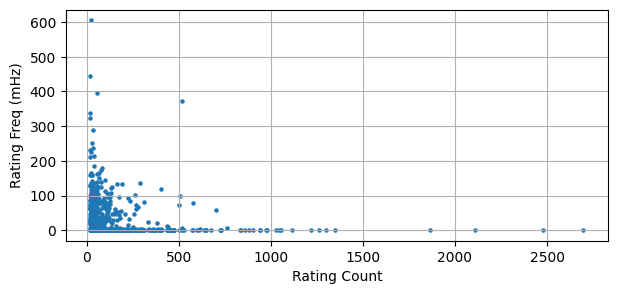

In [19]:
#
# verification frequence de notation par utilisateur
#
def dt_sec(data):
    return data.max() - data.min()

def dt_expanded(data):
    utc_min = datetime.utcfromtimestamp(data.min())
    utc_max = datetime.utcfromtimestamp(data.max())
    dt_full = relativedelta(utc_max, utc_min)
    
    full = []
    if dt_full.years > 0:
        full.append(f"{dt_full.years}y")
    elif dt_full.months > 0:
        full.append(f"{dt_full.months}m")
    elif dt_full.days > 0:
        full.append(f"{dt_full.days}d")
    elif dt_full.hours > 0:
        full.append(f"{dt_full.hours}h")
    else:
        if dt_full.minutes > 0:
            full.append(f"{dt_full.minutes}m")

        if dt_full.seconds > 0:
            full.append(f"{dt_full.seconds}s")
    
    return " ".join(full)

def rating_freq(data):
    num = data.shape[0]
    freq = num / dt_sec(data)
    # mHz pour mieux voir ecarts
    return freq * 1000

user_ratings = mvl_dataset.ratings[["userId", "rating", "timestamp"]] \
                          .groupby(by="userId") \
                          .agg(rating_count=("rating", "count"), 
                               dt_sec=("timestamp", dt_sec),
                               dt_expanded=("timestamp", dt_expanded),
                               rating_freq=("timestamp", rating_freq))

rating_freq_stats = user_ratings.rating_freq.describe().to_frame()
rating_cout_stats = user_ratings.rating_count.describe().to_frame()
fastest_users = user_ratings.nlargest(5, "rating_freq")
slowest_users = user_ratings.nsmallest(5, "rating_freq")

html = jup.horizontify(jup.caption_df(fastest_users.style, "User les plus rapide", caption_bold=False), 
                       jup.caption_df(slowest_users.style, "User les moins rapide", caption_bold=False))
jup.display_html(html)

print()
print("Stats générale")
html = jup.horizontify(rating_freq_stats.style, rating_cout_stats.style)
jup.display_html(html)

#
# visualiser rating_count vs rating_freq
#
def rating_count_vs_freq(user_ratings, critOutliers=None, figsize=(7, 3)):
    plt.figure(figsize=figsize)
    
    if critOutliers is None:
        plt.scatter(user_ratings.rating_count, user_ratings.rating_freq, s=5)
    else:
        outliers = user_ratings[critOutliers]
        plt.scatter(outliers.rating_count, outliers.rating_freq, s=5, label="Outliers")
        
        inliers = user_ratings[~critOutliers]
        plt.scatter(inliers.rating_count, inliers.rating_freq, s=5, label="Inliers")
        
        plt.legend()
    
    plt.grid(True)
    plt.xlabel("Rating Count")
    plt.ylabel("Rating Freq (mHz)")
    plt.show()
    
rating_count_vs_freq(user_ratings)

Les utilisateurs ont votés relativement souvent (20 votes ou plus) mais la distribution est très allongée et fortement concentrée dans les valeurs faible. Le graphe ci-haut suggère que beaucoup de notation semblent avoir étés fait de façon très rapide. Pour illustrer, le user *163* aurait voté 23 fois en 38 secondes (~2 secondes par vote) mais le user *172* aurait pris 1 an pour ses 26 votes. Faute d'information supplémentaire, nous suspectons un système automatisé et enlevons les utilisateurs ayant une fréquence jugée trop élevée.<br><br>
    
En absolue:
$$
\begin{align}
threshold &= Q_3 + 1.5 * IQR\\
          &= 62.19 + 1.5 * (62.19 - 0.04)\\
          &= 155.36\\
\end{align}
$$
  
Une approche basée sur le clustering, plus particulièrement DBSCAN, trouvera les éléments isolés dans le graphe.

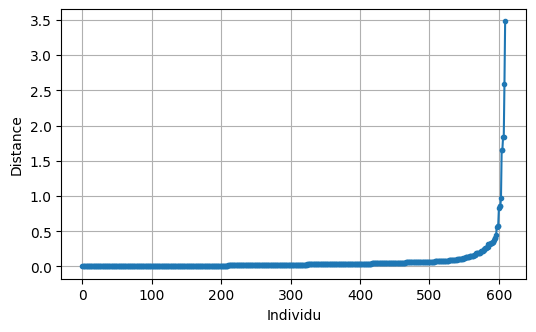

In [20]:
#
# cluster par dbscan pour découvrir les outliers
#
coords = RobustScaler().fit_transform(user_ratings[["rating_count", "rating_freq"]])
clstr.dbscan_eps_analysis(coords, figsize=(6, 3.5))

DBSCAN optimal parameters
eps: 0.44000000000000017
min_samples: 3
silhouette score: 0.7059
# clusters: 3 + ouliers


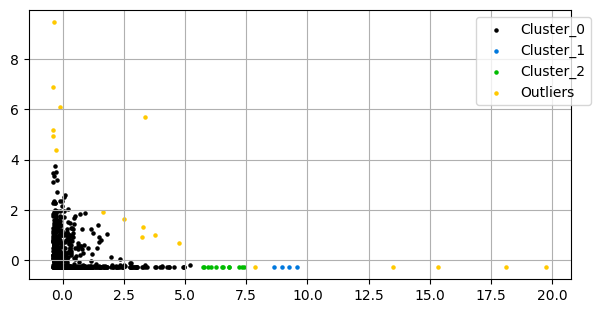

In [21]:
eps_, min_samples_ = clstr.dbscan_parameters_analysis(coords, 
                                                      eps_range=np.arange(0.25, 0.45, 0.01),
                                                      min_samples_range=range(2, 20))
dbscan_ = clstr.dbscan_init(coords, eps_, min_samples_)
clstr.show_clusters(coords, 
                    user_ratings.index, 
                    dbscan_.labels_, 
                    figsize=(7, 3.5),
                    text_alpha=0, 
                    marker_size=5)

Nombre de user outliers 29


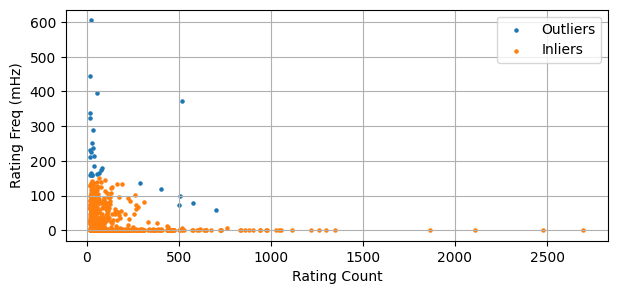

In [22]:
#
# detecter les utilisateurs juges outliers
#
critA = dbscan_.labels_ == -1

# dbscan marque certaines basses frequences 
# s'assurer de les garder
critB = user_ratings.rating_freq > 1

# IQR threshold
critC = user_ratings.rating_freq >= 155.36

# combiner tous les criteres d'outliers
critOutliers = critA & critB | critC

print("Nombre de user outliers", np.count_nonzero(critOutliers))
rating_count_vs_freq(user_ratings, critOutliers)

In [23]:
#
# enlever les utilisateurs juges outliers
#
user_to_remove = user_ratings[critOutliers].index.to_list()
user_to_remove = mvl_dataset.ratings.userId.isin(user_to_remove)
user_to_remove = mvl_dataset.ratings[user_to_remove]

print("ratings avant retrait:", mvl_dataset.ratings.shape[0])
mvl_dataset.ratings.drop(user_to_remove.index, inplace=True, errors="ignore")
print("ratings après retrait:", mvl_dataset.ratings.shape[0])

ratings avant retrait: 100836
ratings après retrait: 96549


Il apparait judicieux d'extraire quelques statistiques sur **rating** afin d'augmenter **movies.csv**.

In [25]:
def mode(ratings):
    # prendre le mode le plus grand
    return ratings.mode().iloc[-1]

def median_keep_category(ratings):
    # garder les modalites de ratings si nombre de valeurs est impaire
    return ratings.quantile(interpolation="nearest")

def join_name(multi_index_name):
    if "" in multi_index_name:
        return multi_index_name[0]
    else:
        return "_".join(multi_index_name)


#
# creer de nouvelles variables
#
ratings_stats = mvl_dataset.ratings[["movieId", "rating"]] \
                           .groupby(by="movieId") \
                           .agg(["count", ("mode", mode), "mean", ("median", median_keep_category)])
ratings_stats.columns = [join_name(a) for a in ratings_stats.columns.to_flat_index()]
ratings_stats.reset_index(inplace=True)
print("Rating stats", ratings_stats.shape)
print("Head")
display(ratings_stats.head().round(2))

Rating stats (9461, 5)
Head


,movieId,rating_count,rating_mode,rating_mean,rating_median
0,1,204,4.0,3.91,4.0
1,2,103,4.0,3.43,3.5
2,3,47,3.0,3.27,3.0
3,4,7,3.0,2.36,3.0
4,5,44,3.0,3.02,3.0


In [26]:
#
# valider que ratings_stats contient bien les meme films que movies.csv
#
movies_ratings = pd.merge(mvl_dataset.movies, ratings_stats, how="left", on="movieId")
movies_ratings_na = clstr.show_na(movies_ratings)

Valeur manquante 281 (2.9%)


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
256,295,0114210,"Pyromaniac's Love Story, A (1995)",Comedy|Romance,1995,NaN,NaN,NaN,NaN
258,298,0105652,Pushing Hands (Tui shou) (1992),Drama,1992,NaN,NaN,NaN,NaN
816,1076,0055018,"Innocents, The (1961)",Horror|Thriller|Drama,1961,NaN,NaN,NaN,NaN
1026,1337,0037549,"Body Snatcher, The (1945)",Horror|Thriller|Drama,1945,NaN,NaN,NaN,NaN
1098,1427,0120390,Turbulence (1997),Action|Thriller,1997,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9725,190209,7620650,Jeff Ross Roasts the Border (2017),Comedy,2017,NaN,NaN,NaN,NaN
9726,190213,3977428,John From (2015),Drama,2015,NaN,NaN,NaN,NaN
9727,190215,7293380,Liquid Truth (2017),Drama,2017,NaN,NaN,NaN,NaN
9728,190219,0179011,Bunny (1998),Animation,1998,NaN,NaN,NaN,NaN


Tous les films n'ont pas reçu de votes. Nous pourrions utiliser le web scraping pour déterminer **rating_mean** mais l'échelle sur IMDB n'est pas la même que MovieLens. De plus les autres statistiques ne pourraient pas être extraite. Comme il n'y a que très peux d'éléments manquants, on les ignore.

In [27]:
#
# enlever valeurs manquantes et valider shape resultante
#
print("movies_ratings avant retrait:", movies_ratings.shape)
movies_ratings.drop(index=movies_ratings_na, axis=0, inplace=True, errors="ignore")
print("movies_ratings après retrait:", movies_ratings.shape)

print()

#
# valider les types (drop() peut changer les choses du aux NA)
#
clstr.show_types(movies_ratings)

movies_ratings avant retrait: (9741, 9)
movies_ratings après retrait: (9460, 9)

Types


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
Type,int64,object,object,object,int64,float64,float64,float64,float64


In [28]:
#
# rating_count est en fait un entier, changer son type
#
movies_ratings.rating_count = movies_ratings.rating_count.astype(np.int64)

# Exploration des nouvelles variables

In [29]:
#
# separe quantitatif et qualitatif
#
quant_cols = ["rating_mode", "rating_median", "rating_mean", "rating_count", "year"]
quant_df = movies_ratings[quant_cols]

qual_cols = ["genres", ]
qual_df = movies_ratings[qual_cols]

Stats générales - variables quantitatives


,count,mean,std,min,25%,50%,75%,max
rating_mode,9460.0,3.48,0.97,0.5,3.00,3.50,4.00,5.0
rating_median,9460.0,3.22,0.94,0.5,3.00,3.50,4.00,5.0
rating_mean,9460.0,3.24,0.86,0.5,2.77,3.39,3.88,5.0
rating_count,9460.0,10.21,21.70,1.0,1.00,3.00,9.00,318.0
year,9460.0,1994.64,18.38,1902.0,1988.00,1999.00,2008.00,2018.0



Distributions - variables quantitatives


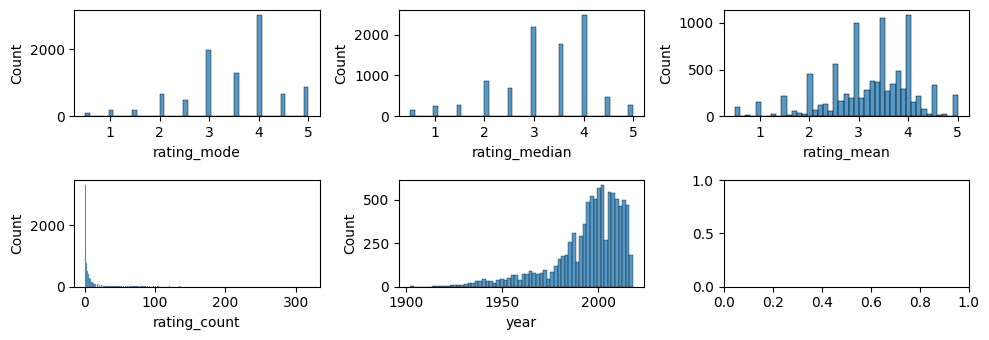

Détails rating_count


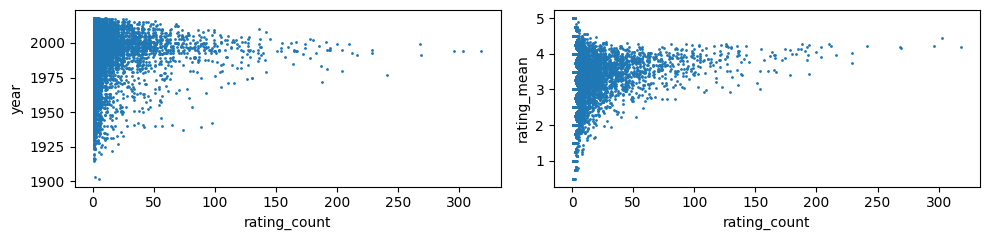

In [30]:
#
# inspection stats et distributions
#
print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=3, figsize=(10, 3.5))

print("Détails rating_count")
plt.figure(figsize=(10, 2.5))

plt.subplot(121)
plt.scatter(quant_df.rating_count, quant_df.year, s=1)
plt.xlabel("rating_count")
plt.ylabel("year")

plt.subplot(122)
plt.scatter(quant_df.rating_count, quant_df.rating_mean, s=1)
plt.xlabel("rating_count")
plt.ylabel("rating_mean")

plt.tight_layout()
plt.show()

<br>**year**

Les films sont relativement récents: peak autour de l'an 2000. La base de données couvre un large spectre et la distribution est allongée (queue à gauche).
    
<br>**rating_count**

Les films sont majoritairement notés par peu de personnes. La distribution très alongée avec un très fort peak dans les faibles valeurs: 75% de la poputlation a moins de 9 votes, 25% n'en a qu'un seul. On pourrait d'interpréter cette métrique comme une mesure de "consensus" sur **rating** mais les 2 derniers graphes montrent bien que ce n'est pas le cas. Les spectres de **year** et **rating** sont couvert. Cette métrique sera enlevée.
    
<br>**rating_mode**, **rating_median** et **rating_mean**

Distrubutions très près d'une gaussienne et multimodales. Aussi très similaire entre elles. On voit bien l'effet des catégories. La majorités des votes sont entre [3, 4]. Il nous apparait plus juste par contre de choisir **rating_mode** pour représenter la variable originelle **rating**. Elle garde l'aspect qualitatif du système de notation et représente la mojorité des votes. **rating_mean** n'est pas adéquat car, comme vu plus haut, il y a peu données en général et elles contiennent le spectre complet du domaine.

In [31]:
#
# enlever rating_count, rating_median et rating_mean
#
to_remove = ["rating_count", "rating_median", "rating_mean"]
movies_ratings.drop(to_remove, axis=1, inplace=True, errors="ignore")
quant_df = quant_df.drop(to_remove, axis=1, errors="ignore")

# Valeurs aberrantes

La distribution de **year** pourrait suggérer des valeurs aberrantes. Par contre, étant donné le contexte d'un sysème de suggestion, il nous apparait plus juste de garder tout garder. En effet, un film des années 80 peut être une meilleure suggestion que certains blockbusters récent. Les autres variables sont de natures qualitatives et sont donc sans valeur aberrante.

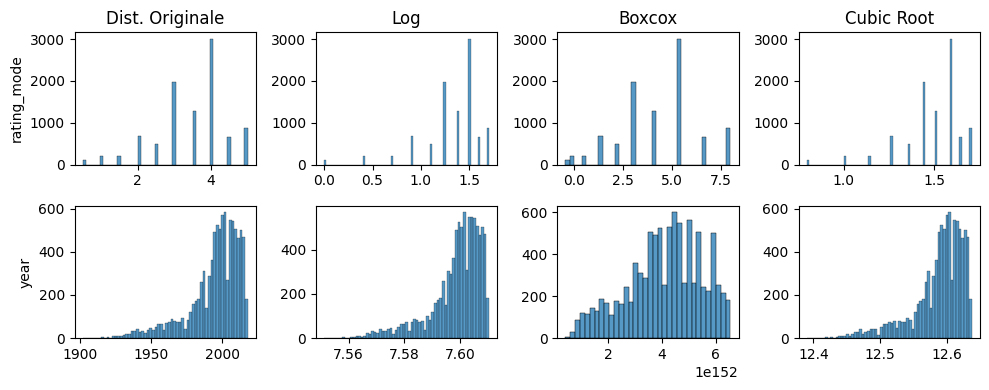

In [32]:
#
# examiner les transformtions
#
quant_transformed = clstr.show_transforms(quant_df, figsize=(10, 4))

* **rating_mode** ne devrait pas être modifé car il représente une variable qualitative
* **year** se rapproche d'une distribution gaussienne via boxcox, nous allons l'ajouter à nos variables

In [33]:
#
# ajouter year transformer par boxcox
#
movies_ratings["year_boxcox"] = quant_transformed.boxcox[0].year

Catégoriser **year** pourrait être intéressant étant donné la nature plutôt qualitative du reste des variables. Nous allons examiner un clustering sur **year** afin de juger du nombre de catégories. Noter que CAH et KMeans seront les algorithmes utilisés. DBSCAN a besoin d'une analyse sur les distance minimale. Hors les années sont systématiquement distante de 1.

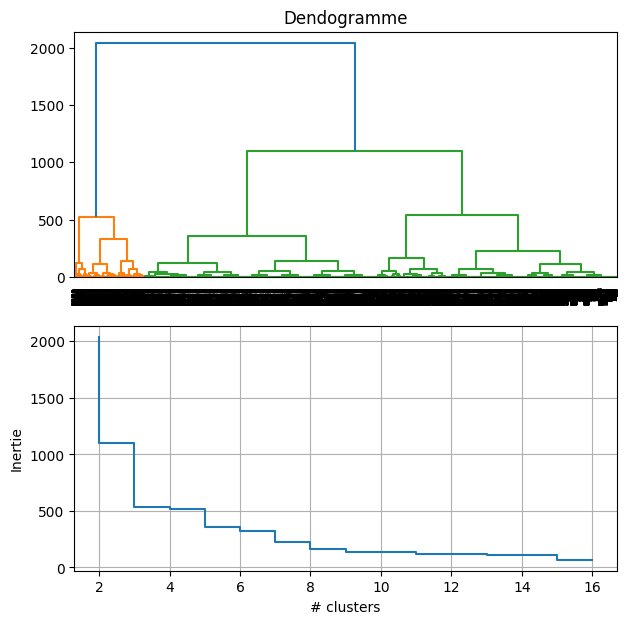

In [34]:
years_df = movies_ratings.year.to_frame()
clstr.cah_analysis(years_df)

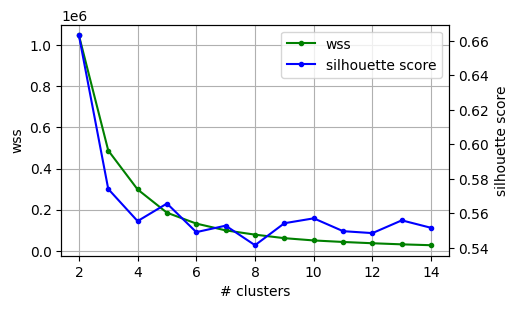

In [35]:
clstr.kmeans_analysis(years_df)

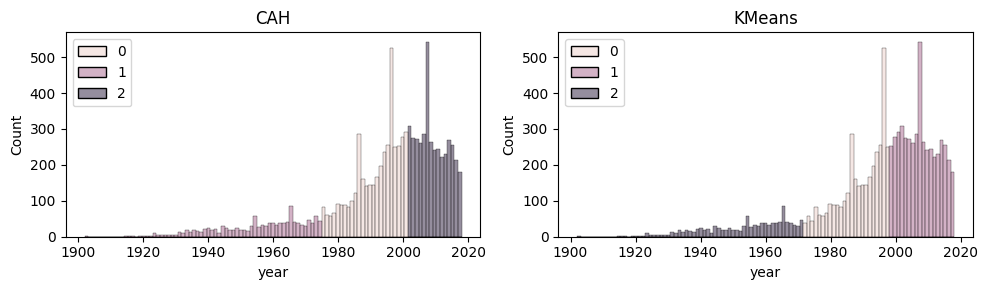

In [36]:
#
# inspection categorisation
#
cah_years = clstr.cah_init(years_df, 3)
kmeans_years = clstr.kmeans_init(years_df, 3)

plt.figure(figsize=(10, 3))
plt.subplot(121)
sns.histplot(x="year",
             bins=movies_ratings.year.nunique(),
             data=movies_ratings, 
             hue=cah_years.labels_, 
             ax=plt.gca())
plt.title("CAH")

plt.subplot(122)
sns.histplot(x="year",
             bins=movies_ratings.year.nunique(),
             data=movies_ratings, 
             hue=kmeans_years.labels_, 
             ax=plt.gca())
plt.title("KMeans")

plt.tight_layout()
plt.show()

CAH et KMeans semblent suggérer 3 clusters. L'inspection visuelle nous apparait également logique. Nous allons ajouter cette catégorisation.

In [37]:
#
# ajout categorisation sur year
#
movies_ratings["year_category"] = cah_years.labels_

Distributions - variables qualitatives


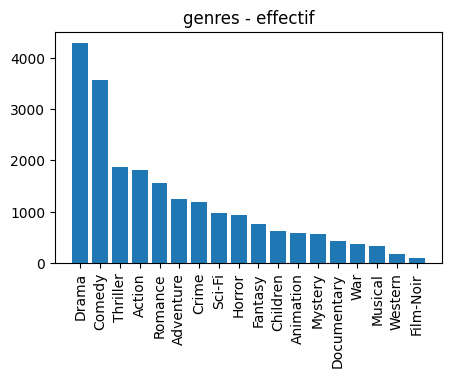

In [38]:
#
# examiner variables qualitatives
#
print("Distributions - variables qualitatives")
genres_ohe_df = qual_df.genres.str.get_dummies(sep=configs.dataset.genre_splitter)
genres_count = genres_ohe_df.sum(axis=0)

genres_df = pd.Series(genres_count,
                      index=genres_count.index,
                      name="count")
genres_df.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(5, 3))
plt.bar(genres_df.index, genres_df.values)
plt.tick_params(axis="x", labelrotation=90)
plt.title("genres - effectif")
plt.show()

* Forte proportion dans Drama et Comedy
* Les modalités sont débalancées

Afin de mitiger le débalancement, il pourrait être judicieux d'appliquer une transformation de type TF-IDF (term frequencey-inverse document frequency) et d'utiliser une métrique de similarité au lieu de distance.

In [39]:
#
# transformatioin tf-idf
#
genres_tf_idf = TfidfTransformer().fit_transform(genres_ohe_df)
genres_tf_idf = pd.DataFrame.sparse.from_spmatrix(genres_tf_idf, 
                                                  index=genres_ohe_df.index,
                                                  columns=genres_ohe_df.columns)
genres_tf_idf.columns = [f"tfidf_{c}" for c in genres_tf_idf.columns]

# validaton par inspection visuelle
print("HEAD genre tf-idf")
display(genres_tf_idf.head())

HEAD genre tf-idf


,tfidf_Action,tfidf_Adventure,tfidf_Animation,tfidf_Children,tfidf_Comedy,tfidf_Crime,tfidf_Documentary,tfidf_Drama,tfidf_Fantasy,tfidf_Film-Noir,tfidf_Horror,tfidf_Musical,tfidf_Mystery,tfidf_Romance,tfidf_Sci-Fi,tfidf_Thriller,tfidf_War,tfidf_Western
0,0.0,0.413531,0.51858,0.506535,0.269500,0.0,0.0,0.000000,0.480478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.509622,0.00000,0.624238,0.000000,0.0,0.0,0.000000,0.592126,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.000000,0.576516,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.817086,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.00000,0.000000,0.511112,0.0,0.0,0.462626,0.000000,0.0,0.0,0.0,0.0,0.724390,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Noter que la transformation one hot ne sera pas ajoutée de par sa nature simple et la redondance d'informations qu'elle ajoute.

In [40]:
#
# ajouter tf-idf
#
movies_final_df = pd.concat([movies_ratings, genres_tf_idf], axis=1)

# validation par inspection de shape
print(movies_final_df.shape)

(9460, 26)


In [41]:
#
# sauvegarde des traitements sur movies_ratings
#
csv_path = mvl_dataset.movies_path.split(".")[0]
csv_path = "".join([csv_path, "_pretraitement", ".csv"])

print("Sauvegarde", csv_path)
movies_final_df.to_csv(csv_path, index=False)

Sauvegarde dataset/movies_pretraitement.csv


# Collaborative filtering

Les systèmes de suggestion ont souvent 2 composantes: "content base" et "collaborative" filtering. L'idée étant d'utiliser l'historique d'un utilisateur (collaborative filtering) et à défaut de l'avoir, utiliser seulement le contenu des fims. Notre base de donnée est plutot simple, nous aurons donc seulement **rating** pour regrouper les utilisateurs.

In [42]:
#
# s'assurer de garder uniquement les uers qui ont les movieId present dans movies_final_df
#
movieIds = movies_final_df.movieId.unique()
ratings = mvl_dataset.ratings[ mvl_dataset.ratings.movieId.isin(movieIds)  ]
user_ratings = ratings.pivot(index="userId", columns="movieId", values="rating")

display(user_ratings)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Données très éparse.

In [43]:
#
# sauvegarde des traitements sur user_ratings
#
csv_path = mvl_dataset.ratings_path.split(".")[0]
csv_path = "".join([csv_path, "_pretraitement", ".csv"])

print("Sauvegarde", csv_path)
user_ratings.to_csv(csv_path, index=False)

Sauvegarde dataset/ratings_pretraitement.csv
